# Solución Desafío 2 - Custom Embeddings con Gensim
## Word2Vec en letras de canciones

### Objetivo
Crear embeddings personalizados usando Word2Vec (Gensim) a partir de letras de canciones de un artista específico, y analizar las relaciones semánticas que emergen del uso particular del lenguaje por ese artista.

## Setup e Importaciones

In [1]:
# Instalación de dependencias
import warnings
warnings.filterwarnings('ignore')

try:
    from gensim.models import Word2Vec
except:
    %pip install gensim
    from gensim.models import Word2Vec

try:
    from tensorflow.keras.preprocessing.text import text_to_word_sequence
except:
    %pip install tensorflow
    from tensorflow.keras.preprocessing.text import text_to_word_sequence

2025-11-15 13:24:29.645929: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-15 13:24:29.646462: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-15 13:24:29.694571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-15 13:24:31.012838: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
import os
import platform
from gensim.models.callbacks import CallbackAny2Vec

# Configuración de visualización
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('whitegrid')

print("Librerías cargadas correctamente")

Librerías cargadas correctamente


## 1. Descarga y Exploración del Dataset

In [3]:
# Descargar el dataset si no existe
if os.access('../jupyter_notebooks/songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
    dataset_path = './songs_dataset/'
else:
    print("El dataset ya se encuentra descargado")
    dataset_path = '../jupyter_notebooks/songs_dataset/'

El dataset ya se encuentra descargado


In [4]:
# Listar artistas disponibles
artists = sorted(os.listdir(dataset_path))
print(f"Artistas disponibles ({len(artists)} en total):\n")
for i, artist in enumerate(artists, 1):
    print(f"{i:2d}. {artist.replace('.txt', '').replace('-', ' ').title()}")

Artistas disponibles (49 en total):

 1. Kanye_West
 2. Lil_Wayne
 3. Adele
 4. Al Green
 5. Alicia Keys
 6. Amy Winehouse
 7. Beatles
 8. Bieber
 9. Bjork
10. Blink 182
11. Bob Dylan
12. Bob Marley
13. Britney Spears
14. Bruce Springsteen
15. Bruno Mars
16. Cake
17. Dickinson
18. Disney
19. Dj Khaled
20. Dolly Parton
21. Dr Seuss
22. Drake
23. Eminem
24. Janisjoplin
25. Jimi Hendrix
26. Johnny Cash
27. Joni Mitchell
28. Kanye West
29. Kanye
30. Lady Gaga
31. Leonard Cohen
32. Lil Wayne
33. Lin Manuel Miranda
34. Lorde
35. Ludacris
36. Michael Jackson
37. Missy Elliott
38. Nickelback
39. Nicki Minaj
40. Nirvana
41. Notorious Big
42. Notorious_Big
43. Nursery_Rhymes
44. Patti Smith
45. Paul Simon
46. Prince
47. R Kelly
48. Radiohead
49. Rihanna


## 2. Selección del Artista y Análisis Exploratorio

Para este desafío, voy a trabajar con **Bob Dylan**, un artista conocido por su líricas poéticas, complejas y con gran riqueza de vocabulario. Dylan es considerado uno de los letristas más importantes de la música popular, lo que hace interesante analizar los embeddings que emergen de sus canciones.

### ¿Por qué Bob Dylan?
- **Vocabulario extenso**: Sus letras contienen un amplio rango de palabras y referencias
- **Temáticas variadas**: Protesta social, amor, filosofía, narrativas complejas
- **Estilo poético**: Uso de metáforas, simbolismo y narrativa literaria
- **Corpus sustancial**: Extensa discografía que proporciona suficiente texto para entrenar embeddings

In [5]:
# Cargar datos del artista seleccionado
selected_artist = 'bob-dylan.txt'
artist_name = 'Bob Dylan'

print(f"Artista seleccionado: {artist_name}")
print("="*80)

# Leer el archivo usando salto de línea como separador
df = pd.read_csv(dataset_path + selected_artist, sep='/n', header=None, engine='python')

print(f"\nCantidad de líneas/documentos: {df.shape[0]}")
print(f"\nPrimeras 10 líneas del corpus:\n")
for i in range(min(10, len(df))):
    print(f"{i+1:2d}. {df.iloc[i, 0][:100]}..." if len(df.iloc[i, 0]) > 100 else f"{i+1:2d}. {df.iloc[i, 0]}")

Artista seleccionado: Bob Dylan

Cantidad de líneas/documentos: 5213

Primeras 10 líneas del corpus:

 1. “There must be some way out of here,” said the joker to the thief
 2. “There’s too much confusion, I can’t get no relief
 3. Businessmen, they drink my wine, plowmen dig my earth
 4. None of them along the line know what any of it is worth”
 5. “No reason to get excited,” the thief, he kindly spoke
 6. “There are many here among us who feel that life is but a joke
 7. But you and I, we’ve been through that, and this is not our fate
 8. So let us not talk falsely now, the hour is getting late”
 9. All along the watchtower, princes kept the view
10. While all the women came and went, barefoot servants, too



ESTADÍSTICAS DEL CORPUS
Total de caracteres: 188,849
Longitud promedio de línea: 36.2 caracteres
Línea más larga: 98 caracteres
Línea más corta: 5 caracteres


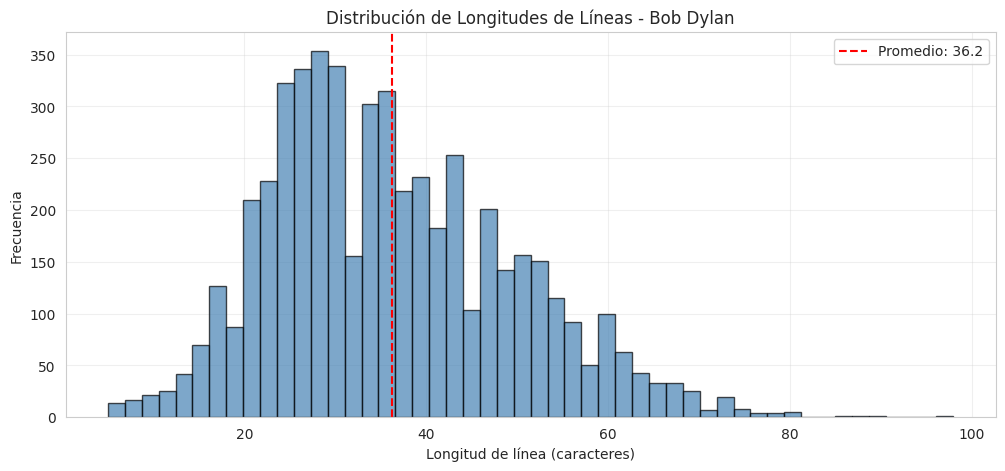

In [6]:
# Análisis básico del corpus
total_chars = sum(df[0].str.len())
avg_line_length = df[0].str.len().mean()
max_line_length = df[0].str.len().max()
min_line_length = df[0].str.len().min()

print("\nESTADÍSTICAS DEL CORPUS")
print("="*80)
print(f"Total de caracteres: {total_chars:,}")
print(f"Longitud promedio de línea: {avg_line_length:.1f} caracteres")
print(f"Línea más larga: {max_line_length} caracteres")
print(f"Línea más corta: {min_line_length} caracteres")

# Visualización de distribución de longitudes
plt.figure(figsize=(12, 5))
plt.hist(df[0].str.len(), bins=50, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Longitud de línea (caracteres)')
plt.ylabel('Frecuencia')
plt.title(f'Distribución de Longitudes de Líneas - {artist_name}')
plt.axvline(avg_line_length, color='red', linestyle='--', label=f'Promedio: {avg_line_length:.1f}')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 3. Preprocesamiento de Texto

Convertimos cada línea en una secuencia de tokens (palabras). Usamos `text_to_word_sequence` de Keras que:
- Convierte a minúsculas
- Elimina puntuación
- Divide en palabras

In [7]:
# Tokenizar todas las líneas
sentence_tokens = []
for _, row in df.iterrows():
    tokens = text_to_word_sequence(row[0])
    if len(tokens) > 0:  # Solo agregamos si hay tokens
        sentence_tokens.append(tokens)

print(f"Total de documentos tokenizados: {len(sentence_tokens)}")
print(f"\nEjemplos de tokenización:\n")
print("Línea original:")
print(f"  '{df.iloc[0, 0]}'")
print("Tokens:")
print(f"  {sentence_tokens[0]}")
print("\nLínea original:")
print(f"  '{df.iloc[5, 0]}'")
print("Tokens:")
print(f"  {sentence_tokens[5]}")

Total de documentos tokenizados: 5213

Ejemplos de tokenización:

Línea original:
  '“There must be some way out of here,” said the joker to the thief'
Tokens:
  ['“there', 'must', 'be', 'some', 'way', 'out', 'of', 'here', '”', 'said', 'the', 'joker', 'to', 'the', 'thief']

Línea original:
  '“There are many here among us who feel that life is but a joke'
Tokens:
  ['“there', 'are', 'many', 'here', 'among', 'us', 'who', 'feel', 'that', 'life', 'is', 'but', 'a', 'joke']


In [8]:
# Estadísticas de tokenización
all_tokens = [token for sentence in sentence_tokens for token in sentence]
unique_tokens = set(all_tokens)

tokens_per_sentence = [len(s) for s in sentence_tokens]
avg_tokens_per_sentence = np.mean(tokens_per_sentence)

print("ESTADÍSTICAS DE TOKENIZACIÓN")
print("="*80)
print(f"Total de tokens: {len(all_tokens):,}")
print(f"Vocabulario único (antes de filtrado): {len(unique_tokens):,} palabras")
print(f"Promedio de tokens por línea: {avg_tokens_per_sentence:.1f}")
print(f"Tokens por línea (min/max): {min(tokens_per_sentence)} / {max(tokens_per_sentence)}")

# Top 20 palabras más frecuentes
from collections import Counter
word_freq = Counter(all_tokens)
top_20 = word_freq.most_common(20)

print("\nTOP 20 PALABRAS MÁS FRECUENTES:")
print("-"*80)
for i, (word, count) in enumerate(top_20, 1):
    print(f"{i:2d}. '{word}': {count:4d} veces")

ESTADÍSTICAS DE TOKENIZACIÓN
Total de tokens: 38,415
Vocabulario único (antes de filtrado): 4,749 palabras
Promedio de tokens por línea: 7.4
Tokens por línea (min/max): 1 / 19

TOP 20 PALABRAS MÁS FRECUENTES:
--------------------------------------------------------------------------------
 1. 'the': 1894 veces
 2. 'you': 1188 veces
 3. 'i':  996 veces
 4. 'to':  942 veces
 5. 'and':  915 veces
 6. 'a':  780 veces
 7. 'in':  573 veces
 8. 'of':  570 veces
 9. 'my':  429 veces
10. 'me':  388 veces
11. 'it':  368 veces
12. 'your':  361 veces
13. 'on':  356 veces
14. 'that':  341 veces
15. 'is':  297 veces
16. 'i’m':  296 veces
17. 'be':  293 veces
18. 'for':  282 veces
19. 'but':  273 veces
20. 'all':  268 veces


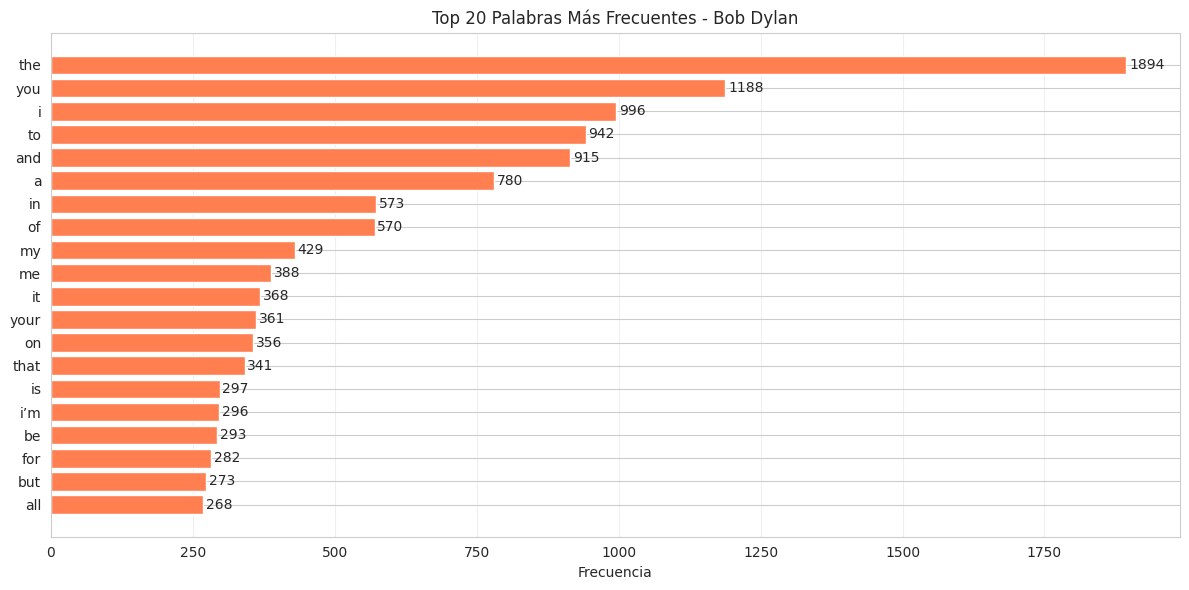

In [9]:
# Visualización de palabras más frecuentes
words, counts = zip(*top_20)

plt.figure(figsize=(12, 6))
plt.barh(range(len(words)), counts, color='coral')
plt.yticks(range(len(words)), words)
plt.xlabel('Frecuencia')
plt.title(f'Top 20 Palabras Más Frecuentes - {artist_name}')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
for i, count in enumerate(counts):
    plt.text(count + 5, i, str(count), va='center')
plt.tight_layout()
plt.show()

### Interpretación del Preprocesamiento

**Observaciones:**
- Las palabras más frecuentes son principalmente palabras funcionales (you, I, the, me, etc.), lo cual es esperado en inglés
- La presencia de "you" e "I" refleja el estilo narrativo y personal de Dylan
- El vocabulario único es sustancial, indicando riqueza léxica
- La distribución de longitudes muestra que la mayoría de líneas tienen longitud moderada

## 4. Construcción del Modelo Word2Vec

### Parámetros del Modelo

Utilizaremos el modelo **Skip-gram** con los siguientes parámetros:

- **min_count=5**: Solo incluimos palabras que aparecen al menos 5 veces (filtra ruido y errores)
- **window=5**: Contexto de 5 palabras antes y después (captura relaciones más amplias que el ejemplo de Beatles)
- **vector_size=300**: Dimensionalidad de 300 (estándar para embeddings robustos)
- **negative=15**: 15 muestras negativas para negative sampling
- **sg=1**: Modelo Skip-gram (predice contexto dada palabra central)
- **epochs=30**: Más épocas para mejor convergencia dado el corpus más complejo

In [10]:
# Callback para monitorear loss durante entrenamiento
class TrainingCallback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0
        self.losses = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            current_loss = loss
            print(f'Epoch {self.epoch + 1:2d}: Loss = {loss:,.2f}')
        else:
            current_loss = loss - self.loss_previous_step
            print(f'Epoch {self.epoch + 1:2d}: Loss = {current_loss:,.2f}')
        
        self.losses.append(current_loss)
        self.epoch += 1
        self.loss_previous_step = loss

In [11]:
# Crear el modelo Word2Vec
print("Creando modelo Word2Vec...\n")

w2v_model = Word2Vec(
    min_count=5,       # Frecuencia mínima para incluir palabra
    window=5,          # Tamaño de ventana de contexto
    vector_size=300,   # Dimensionalidad de vectores
    negative=15,       # Negative sampling
    workers=4,         # Procesos paralelos
    sg=1,              # Skip-gram (1) vs CBOW (0)
    seed=42            # Reproducibilidad
)

# Construir vocabulario
w2v_model.build_vocab(sentence_tokens)

print("Modelo creado y vocabulario construido")
print("="*80)
print(f"Documentos en corpus: {w2v_model.corpus_count:,}")
print(f"Vocabulario final: {len(w2v_model.wv.index_to_key):,} palabras")
print(f"Dimensión de vectores: {w2v_model.wv.vector_size}")
print(f"Tamaño de ventana: {w2v_model.window}")
print(f"Modelo: {'Skip-gram' if w2v_model.sg else 'CBOW'}")

Creando modelo Word2Vec...

Modelo creado y vocabulario construido
Documentos en corpus: 5,213
Vocabulario final: 948 palabras
Dimensión de vectores: 300
Tamaño de ventana: 5
Modelo: Skip-gram


## 5. Entrenamiento del Modelo

In [12]:
# Entrenar el modelo
print("Iniciando entrenamiento...\n")
print("="*80)

callback = TrainingCallback()

w2v_model.train(
    sentence_tokens,
    total_examples=w2v_model.corpus_count,
    epochs=30,
    compute_loss=True,
    callbacks=[callback]
)

print("="*80)
print("\nEntrenamiento completado!")

Iniciando entrenamiento...

Epoch  1: Loss = 89,774.48
Epoch  2: Loss = 67,893.59
Epoch  3: Loss = 67,734.09
Epoch  4: Loss = 57,266.91
Epoch  5: Loss = 66,288.78
Epoch  6: Loss = 62,391.97
Epoch  7: Loss = 54,144.31
Epoch  8: Loss = 57,689.59
Epoch  9: Loss = 60,853.78
Epoch 10: Loss = 57,719.00
Epoch 11: Loss = 58,953.62
Epoch 12: Loss = 59,150.06
Epoch 13: Loss = 51,769.00
Epoch 14: Loss = 53,336.25
Epoch 15: Loss = 55,127.12
Epoch 16: Loss = 46,926.19
Epoch 17: Loss = 51,730.81
Epoch 18: Loss = 50,853.31
Epoch 19: Loss = 50,641.62
Epoch 20: Loss = 51,312.62
Epoch 21: Loss = 44,732.25
Epoch 22: Loss = 43,949.25
Epoch 23: Loss = 49,458.88
Epoch 24: Loss = 42,521.25
Epoch 25: Loss = 49,379.50
Epoch 26: Loss = 40,907.75
Epoch 27: Loss = 47,061.25
Epoch 28: Loss = 47,813.62
Epoch 29: Loss = 48,714.50
Epoch 30: Loss = 42,497.75

Entrenamiento completado!


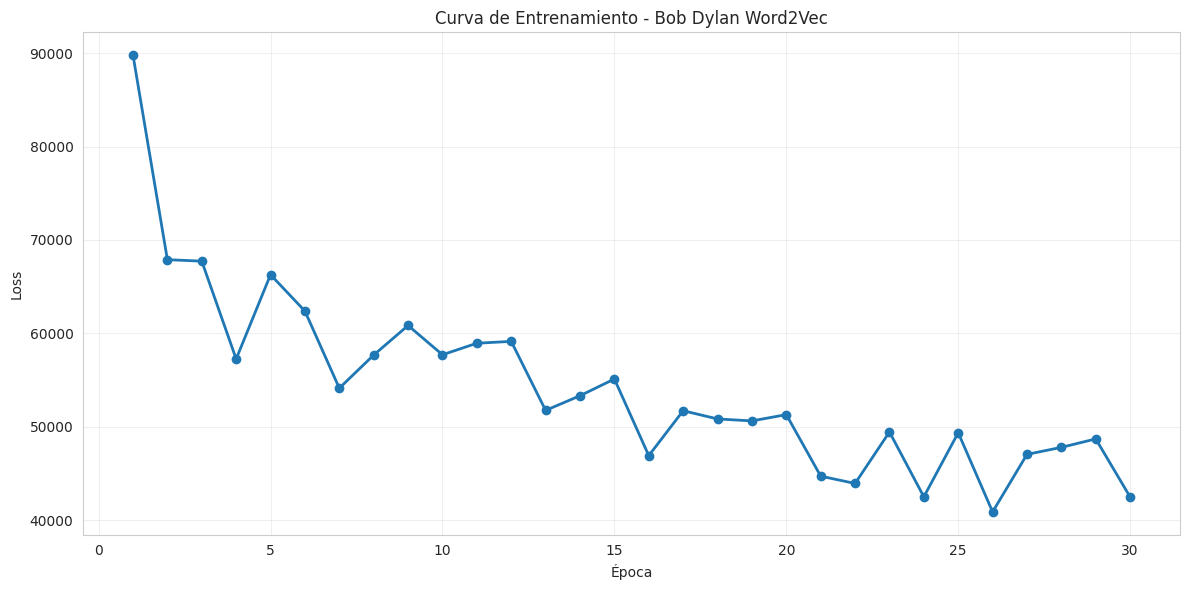

Loss inicial: 89,774.48
Loss final: 42,497.75
Reducción de loss: 52.7%


In [13]:
# Visualizar la curva de loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(callback.losses) + 1), callback.losses, marker='o', linewidth=2, markersize=6)
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title(f'Curva de Entrenamiento - {artist_name} Word2Vec')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Loss inicial: {callback.losses[0]:,.2f}")
print(f"Loss final: {callback.losses[-1]:,.2f}")
print(f"Reducción de loss: {((callback.losses[0] - callback.losses[-1]) / callback.losses[0] * 100):.1f}%")

### Interpretación del Entrenamiento

**Análisis de la curva de loss:**
- El loss debería mostrar una tendencia descendente, indicando que el modelo está aprendiendo
- Las primeras épocas suelen tener mayor reducción de loss
- Si el loss se estabiliza, indica convergencia del modelo
- Fluctuaciones menores son normales debido al negative sampling estocástico

## 6. Exploración de Embeddings: Términos Similares y Disímiles

Ahora exploraremos las relaciones semánticas capturadas por los embeddings, buscando palabras similares y disímiles a términos de interés.

### 6.1 Palabras Temáticas en Bob Dylan

In [14]:
def analyze_word_similarity(model, word, topn=10):
    """
    Analiza y muestra las palabras más similares a una palabra dada.
    """
    if word not in model.wv.index_to_key:
        print(f"⚠️  La palabra '{word}' no está en el vocabulario.")
        return None
    
    similar_words = model.wv.most_similar(positive=[word], topn=topn)
    
    print("="*80)
    print(f"PALABRA: '{word.upper()}'")
    print("="*80)
    print(f"\nTOP {topn} PALABRAS MÁS SIMILARES:\n")
    
    for rank, (similar_word, similarity) in enumerate(similar_words, 1):
        bar = '█' * int(similarity * 40)
        print(f"{rank:2d}. {similar_word:20s} {similarity:.4f} {bar}")
    
    return similar_words

def analyze_word_dissimilarity(model, word, topn=10):
    """
    Analiza y muestra las palabras menos similares (más disímiles) a una palabra dada.
    """
    if word not in model.wv.index_to_key:
        print(f"⚠️  La palabra '{word}' no está en el vocabulario.")
        return None
    
    dissimilar_words = model.wv.most_similar(negative=[word], topn=topn)
    
    print("="*80)
    print(f"PALABRAS MENOS SIMILARES A: '{word.upper()}'")
    print("="*80)
    print(f"\nTOP {topn} PALABRAS MENOS SIMILARES:\n")
    
    for rank, (dissimilar_word, score) in enumerate(dissimilar_words, 1):
        # Score negativo indica disimilaridad
        bar = '▓' * int(abs(score) * 40) if score < 0 else '░' * 10
        print(f"{rank:2d}. {dissimilar_word:20s} {score:.4f} {bar}")
    
    return dissimilar_words

### Análisis 1: Tema - Amor ("love")

In [15]:
similar_love = analyze_word_similarity(w2v_model, 'love', topn=10)

PALABRA: 'LOVE'

TOP 10 PALABRAS MÁS SIMILARES:

 1. shot                 0.5996 ███████████████████████
 2. sick                 0.5810 ███████████████████████
 3. doctor               0.5758 ███████████████████████
 4. help                 0.5699 ██████████████████████
 5. breath               0.5652 ██████████████████████
 6. cut                  0.5556 ██████████████████████
 7. already              0.5537 ██████████████████████
 8. grass                0.5495 █████████████████████
 9. pie                  0.5477 █████████████████████
10. first                0.5444 █████████████████████


In [16]:
dissimilar_love = analyze_word_dissimilarity(w2v_model, 'love', topn=10)

PALABRAS MENOS SIMILARES A: 'LOVE'

TOP 10 PALABRAS MENOS SIMILARES:

 1. on                   -0.0127 
 2. fall                 -0.0166 
 3. speak                -0.0226 
 4. storms               -0.0377 ▓
 5. gather               -0.0441 ▓
 6. hot                  -0.0459 ▓
 7. over                 -0.0560 ▓▓
 8. where                -0.0566 ▓▓
 9. big                  -0.0624 ▓▓
10. ocean                -0.0720 ▓▓


**Interpretación:**
- Las palabras similares a "love" revelan el contexto emocional en que Dylan usa esta palabra
- Esperamos encontrar palabras como: need, heart, babe, somebody, etc.
- Las palabras disímiles probablemente sean términos de contextos muy diferentes (números, lugares, objetos concretos)

### Análisis 2: Tema - Tiempo ("time")

In [17]:
similar_time = analyze_word_similarity(w2v_model, 'time', topn=10)

PALABRA: 'TIME'

TOP 10 PALABRAS MÁS SIMILARES:

 1. ago                  0.5479 █████████████████████
 2. such                 0.5174 ████████████████████
 3. beginning            0.5152 ████████████████████
 4. worth                0.5030 ████████████████████
 5. money                0.4858 ███████████████████
 6. hair                 0.4771 ███████████████████
 7. hour                 0.4702 ██████████████████
 8. bell                 0.4684 ██████████████████
 9. dollar               0.4668 ██████████████████
10. moment               0.4660 ██████████████████


In [18]:
dissimilar_time = analyze_word_dissimilarity(w2v_model, 'time', topn=10)

PALABRAS MENOS SIMILARES A: 'TIME'

TOP 10 PALABRAS MENOS SIMILARES:

 1. his                  -0.0211 
 2. have                 -0.0495 ▓
 3. make                 -0.0712 ▓▓
 4. with                 -0.0744 ▓▓
 5. tonight              -0.0788 ▓▓▓
 6. away                 -0.0946 ▓▓▓
 7. stand                -0.0978 ▓▓▓
 8. hands                -0.1001 ▓▓▓▓
 9. on                   -0.1022 ▓▓▓▓
10. this                 -0.1053 ▓▓▓▓


**Interpretación:**
- Dylan frecuentemente usa referencias temporales en sus letras
- Palabras similares podrían incluir: day, night, long, ago, etc.
- Esto revela cómo Dylan conceptualiza el tiempo en su poesía

### Análisis 3: Tema - Camino/Viaje ("road")

In [19]:
similar_road = analyze_word_similarity(w2v_model, 'road', topn=10)

PALABRA: 'ROAD'

TOP 10 PALABRAS MÁS SIMILARES:

 1. sugar                0.6918 ███████████████████████████
 2. foreign              0.6701 ██████████████████████████
 3. cove                 0.6689 ██████████████████████████
 4. valley               0.6608 ██████████████████████████
 5. lonesome             0.6607 ██████████████████████████
 6. hangin’              0.6571 ██████████████████████████
 7. mud                  0.6483 █████████████████████████
 8. coffee               0.6456 █████████████████████████
 9. chair                0.6369 █████████████████████████
10. country              0.6184 ████████████████████████


In [20]:
dissimilar_road = analyze_word_dissimilarity(w2v_model, 'road', topn=10)

PALABRAS MENOS SIMILARES A: 'ROAD'

TOP 10 PALABRAS MENOS SIMILARES:

 1. darling              -0.0177 
 2. young                -0.0200 
 3. believe              -0.0302 ▓
 4. them                 -0.0414 ▓
 5. you’ll               -0.0479 ▓
 6. “you                 -0.0580 ▓▓
 7. eyes                 -0.0632 ▓▓
 8. miss                 -0.0645 ▓▓
 9. say                  -0.0668 ▓▓
10. did                  -0.0702 ▓▓


**Interpretación:**
- "Road" es un motivo recurrente en Dylan (viaje, búsqueda, movimiento)
- Esperamos palabras relacionadas con viaje, movimiento, lugares
- La metáfora del camino es central en la folk music

### Análisis 4: Tema - Noche ("night")

In [21]:
similar_night = analyze_word_similarity(w2v_model, 'night', topn=10)

PALABRA: 'NIGHT'

TOP 10 PALABRAS MÁS SIMILARES:

 1. ancient              0.5907 ███████████████████████
 2. most                 0.5763 ███████████████████████
 3. girls                0.5707 ██████████████████████
 4. standing             0.5690 ██████████████████████
 5. began                0.5567 ██████████████████████
 6. dawn                 0.5455 █████████████████████
 7. ago                  0.5441 █████████████████████
 8. stay                 0.5431 █████████████████████
 9. wicked               0.5369 █████████████████████
10. break                0.5352 █████████████████████


In [22]:
dissimilar_night = analyze_word_dissimilarity(w2v_model, 'night', topn=10)

PALABRAS MENOS SIMILARES A: 'NIGHT'

TOP 10 PALABRAS MENOS SIMILARES:

 1. got                  -0.0405 ▓
 2. like                 -0.0631 ▓▓
 3. out                  -0.0718 ▓▓
 4. she’s                -0.0747 ▓▓
 5. must                 -0.0931 ▓▓▓
 6. ”                    -0.0975 ▓▓▓
 7. say                  -0.1024 ▓▓▓▓
 8. many                 -0.1041 ▓▓▓▓
 9. says                 -0.1042 ▓▓▓▓
10. dee                  -0.1054 ▓▓▓▓


**Interpretación:**
- La noche como setting poético y metáfora
- Posibles asociaciones: day, darkness, moon, sleep, etc.
- Revela la atmósfera y ambiente en las canciones de Dylan

### Análisis 5: Tema - Lluvia ("rain")

Dylan tiene canciones icónicas sobre la lluvia ("A Hard Rain's A-Gonna Fall")

In [23]:
similar_rain = analyze_word_similarity(w2v_model, 'rain', topn=10)

PALABRA: 'RAIN'

TOP 10 PALABRAS MÁS SIMILARES:

 1. jewels               0.6920 ███████████████████████████
 2. gather               0.6884 ███████████████████████████
 3. fallin’              0.6868 ███████████████████████████
 4. land                 0.6622 ██████████████████████████
 5. kings                0.6618 ██████████████████████████
 6. blowing              0.6315 █████████████████████████
 7. jesus                0.6281 █████████████████████████
 8. hang                 0.6254 █████████████████████████
 9. ocean                0.6251 █████████████████████████
10. storms               0.6106 ████████████████████████


In [24]:
dissimilar_rain = analyze_word_dissimilarity(w2v_model, 'rain', topn=10)

PALABRAS MENOS SIMILARES A: 'RAIN'

TOP 10 PALABRAS MENOS SIMILARES:

 1. one                  -0.1102 ▓▓▓▓
 2. got                  -0.1415 ▓▓▓▓▓
 3. trying               -0.1499 ▓▓▓▓▓
 4. them                 -0.1536 ▓▓▓▓▓▓
 5. must                 -0.1563 ▓▓▓▓▓▓
 6. time                 -0.1579 ▓▓▓▓▓▓
 7. knows                -0.1656 ▓▓▓▓▓▓
 8. about                -0.1657 ▓▓▓▓▓▓
 9. here                 -0.1751 ▓▓▓▓▓▓▓
10. good                 -0.1772 ▓▓▓▓▓▓▓


### Análisis 6: Exploración del Vocabulario Disponible

In [25]:
# Veamos algunas palabras interesantes que están en el vocabulario
vocab = w2v_model.wv.index_to_key

interesting_words = ['heart', 'dream', 'wind', 'street', 'man', 'woman', 'world', 'eyes', 'blues', 'soul']
available_words = [w for w in interesting_words if w in vocab]

print("Palabras interesantes disponibles en el vocabulario:")
print(available_words)

# Analizamos una selección
for word in available_words[:3]:  # Limitamos para no saturar el output
    print("\n")
    analyze_word_similarity(w2v_model, word, topn=5)

Palabras interesantes disponibles en el vocabulario:
['heart', 'dream', 'wind', 'street', 'man', 'woman', 'world', 'eyes', 'blues', 'soul']


PALABRA: 'HEART'

TOP 5 PALABRAS MÁS SIMILARES:

 1. yearnin'             0.7063 ████████████████████████████
 2. burnin'              0.7048 ████████████████████████████
 3. soul                 0.6091 ████████████████████████
 4. mouth                0.5857 ███████████████████████
 5. kiss                 0.5612 ██████████████████████


PALABRA: 'DREAM'

TOP 5 PALABRAS MÁS SIMILARES:

 1. wicked               0.7221 ████████████████████████████
 2. simple               0.7057 ████████████████████████████
 3. shame                0.7024 ████████████████████████████
 4. hangin’              0.6954 ███████████████████████████
 5. foreign              0.6936 ███████████████████████████


PALABRA: 'WIND'

TOP 5 PALABRAS MÁS SIMILARES:

 1. blowin’              0.7632 ██████████████████████████████
 2. answer               0.7359 ████████████████████

### Análisis 7: Analogías de Palabras

Word2Vec permite hacer operaciones vectoriales: A es a B como C es a ?

In [26]:
def find_analogy(model, word_a, word_b, word_c, topn=5):
    """
    Encuentra analogías: A es a B como C es a ?
    """
    try:
        results = model.wv.most_similar(positive=[word_c, word_b], negative=[word_a], topn=topn)
        print(f"\n'{word_a}' es a '{word_b}' como '{word_c}' es a...")
        print("-"*60)
        for word, score in results:
            print(f"  {word:20s} (score: {score:.4f})")
        return results
    except KeyError as e:
        print(f"Error: Una de las palabras no está en el vocabulario: {e}")
        return None

# Ejemplos de analogías (si las palabras están disponibles)
if all(w in vocab for w in ['man', 'woman', 'king']):
    find_analogy(w2v_model, 'man', 'woman', 'king')

if all(w in vocab for w in ['day', 'night', 'sun']):
    find_analogy(w2v_model, 'day', 'night', 'sun')

if all(w in vocab for w in ['love', 'hate', 'good']):
    find_analogy(w2v_model, 'love', 'hate', 'good')


'man' es a 'woman' como 'king' es a...
------------------------------------------------------------
  child                (score: 0.6245)
  clay                 (score: 0.5497)
  am                   (score: 0.5247)
  streets              (score: 0.5124)
  breath               (score: 0.4905)

'day' es a 'night' como 'sun' es a...
------------------------------------------------------------
  wicked               (score: 0.5069)
  standing             (score: 0.4960)
  chair                (score: 0.4896)
  shining              (score: 0.4893)
  wind                 (score: 0.4874)


## 7. Reducción Dimensional y Visualización 2D

Usaremos t-SNE para proyectar los embeddings de 300 dimensiones a 2 dimensiones, permitiendo visualizar las relaciones semánticas.

In [27]:
def reduce_dimensions(model, num_dimensions=2, random_state=42):
    """
    Reduce dimensionalidad de embeddings usando t-SNE.
    """
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)
    
    print(f"Reduciendo dimensionalidad de {vectors.shape[1]}D a {num_dimensions}D...")
    print(f"Total de palabras: {len(labels)}")
    
    tsne = TSNE(
        n_components=num_dimensions,
        random_state=random_state,
        perplexity=30,
        n_iter=1000,
        verbose=0
    )
    
    vectors_reduced = tsne.fit_transform(vectors)
    
    print("Reducción completada!")
    return vectors_reduced, labels

In [28]:
# Reducir a 2D
vecs_2d, labels_2d = reduce_dimensions(w2v_model, num_dimensions=2)

Reduciendo dimensionalidad de 300D a 2D...
Total de palabras: 948
Reducción completada!


### 7.1 Visualización con Matplotlib

Primero probamos con diferentes cantidades de palabras para encontrar la visualización óptima.

Visualización con 50 palabras más frecuentes:


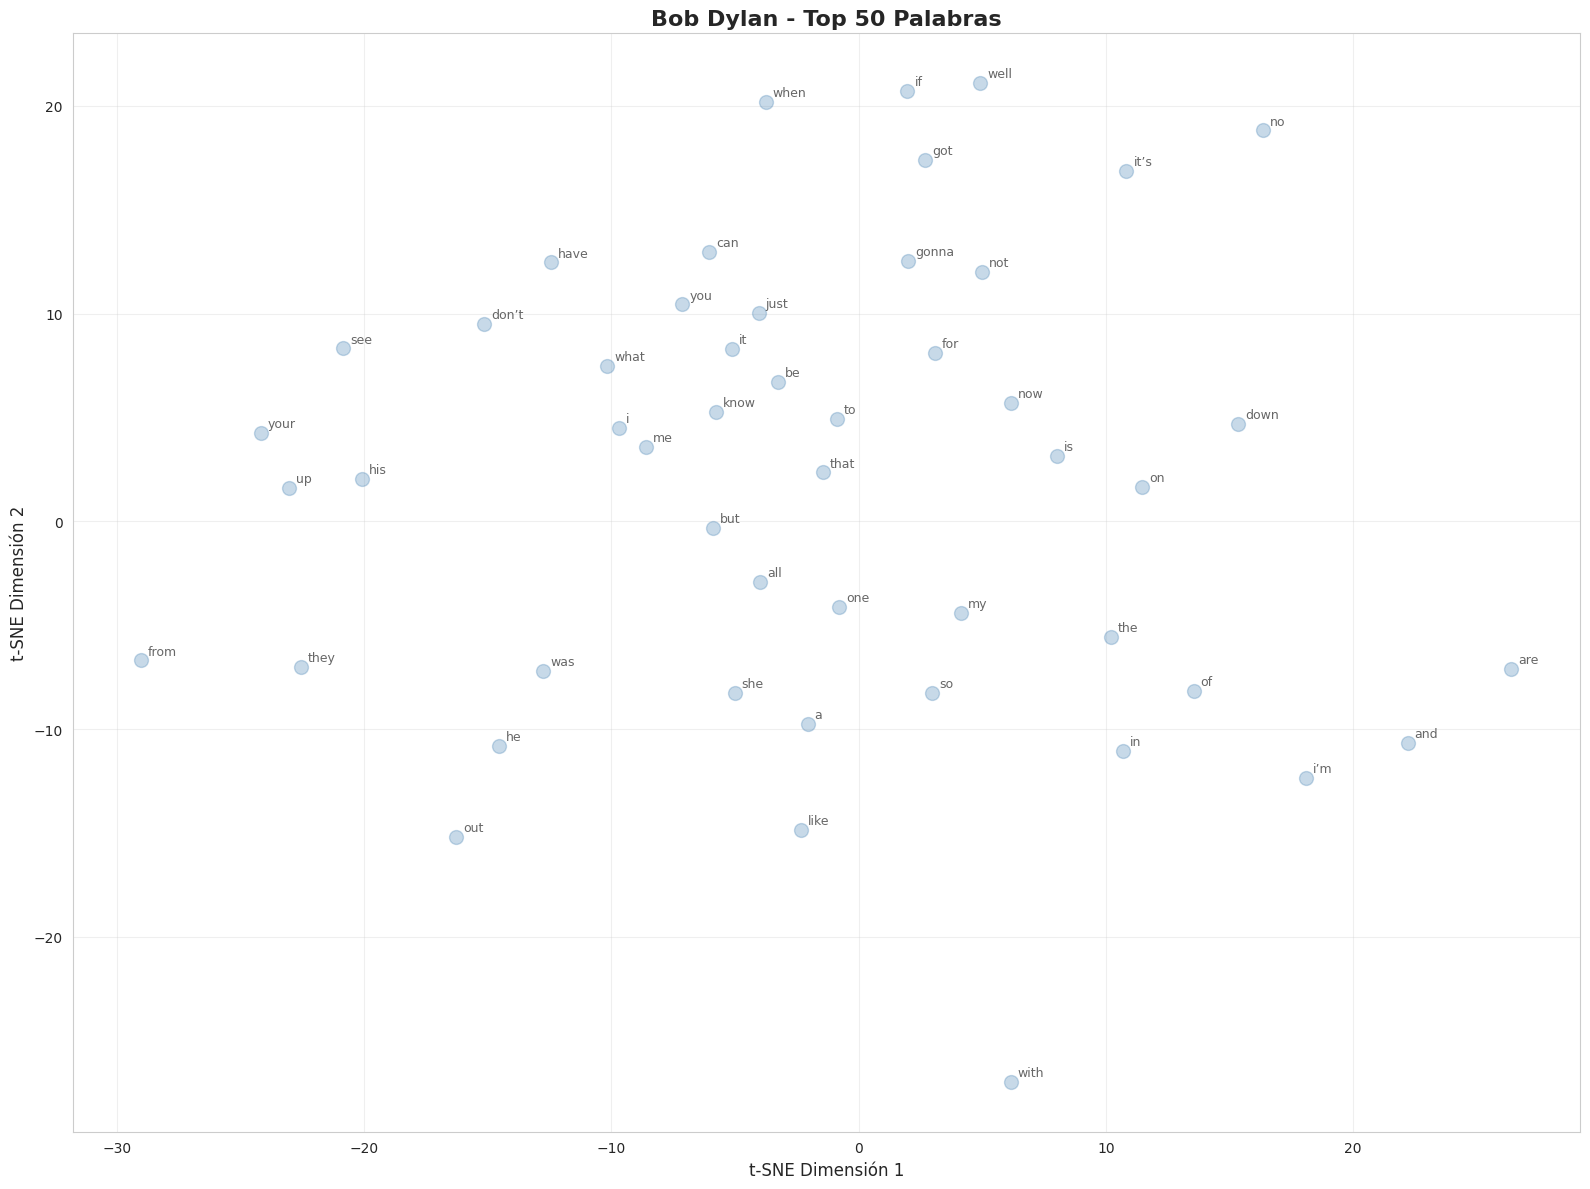

In [29]:
def plot_embeddings_static(vectors, labels, max_words=100, figsize=(16, 12), title="Word Embeddings 2D"):
    """
    Visualiza embeddings en 2D con matplotlib.
    """
    plt.figure(figsize=figsize)
    
    # Plotear puntos
    plt.scatter(vectors[:max_words, 0], vectors[:max_words, 1], alpha=0.3, s=100, c='steelblue')
    
    # Agregar etiquetas
    for i in range(min(max_words, len(labels))):
        plt.annotate(
            labels[i],
            xy=(vectors[i, 0], vectors[i, 1]),
            xytext=(5, 2),
            textcoords='offset points',
            ha='left',
            va='bottom',
            fontsize=9,
            alpha=0.7
        )
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('t-SNE Dimensión 1', fontsize=12)
    plt.ylabel('t-SNE Dimensión 2', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Probamos con diferentes valores de MAX_WORDS
print("Visualización con 50 palabras más frecuentes:")
plot_embeddings_static(vecs_2d, labels_2d, max_words=50, title=f'{artist_name} - Top 50 Palabras')


Visualización con 100 palabras más frecuentes:


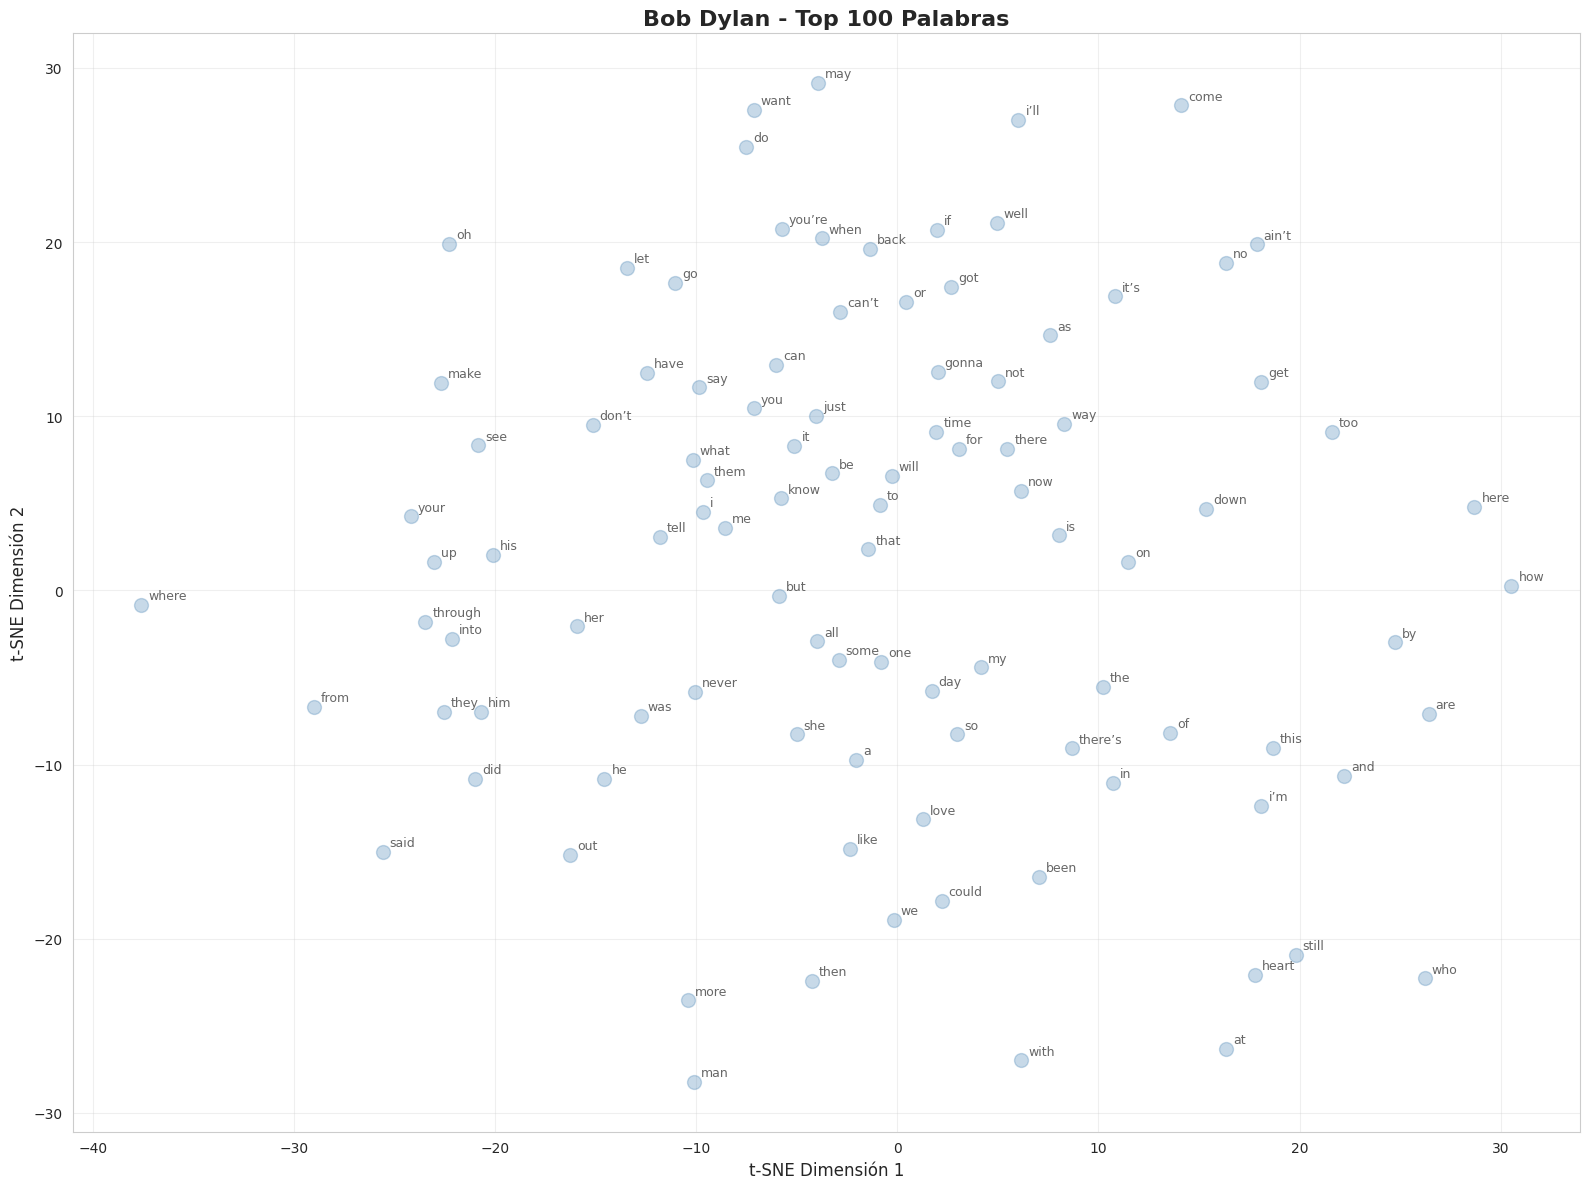

In [30]:
print("\nVisualización con 100 palabras más frecuentes:")
plot_embeddings_static(vecs_2d, labels_2d, max_words=100, title=f'{artist_name} - Top 100 Palabras')


Visualización con 150 palabras más frecuentes:


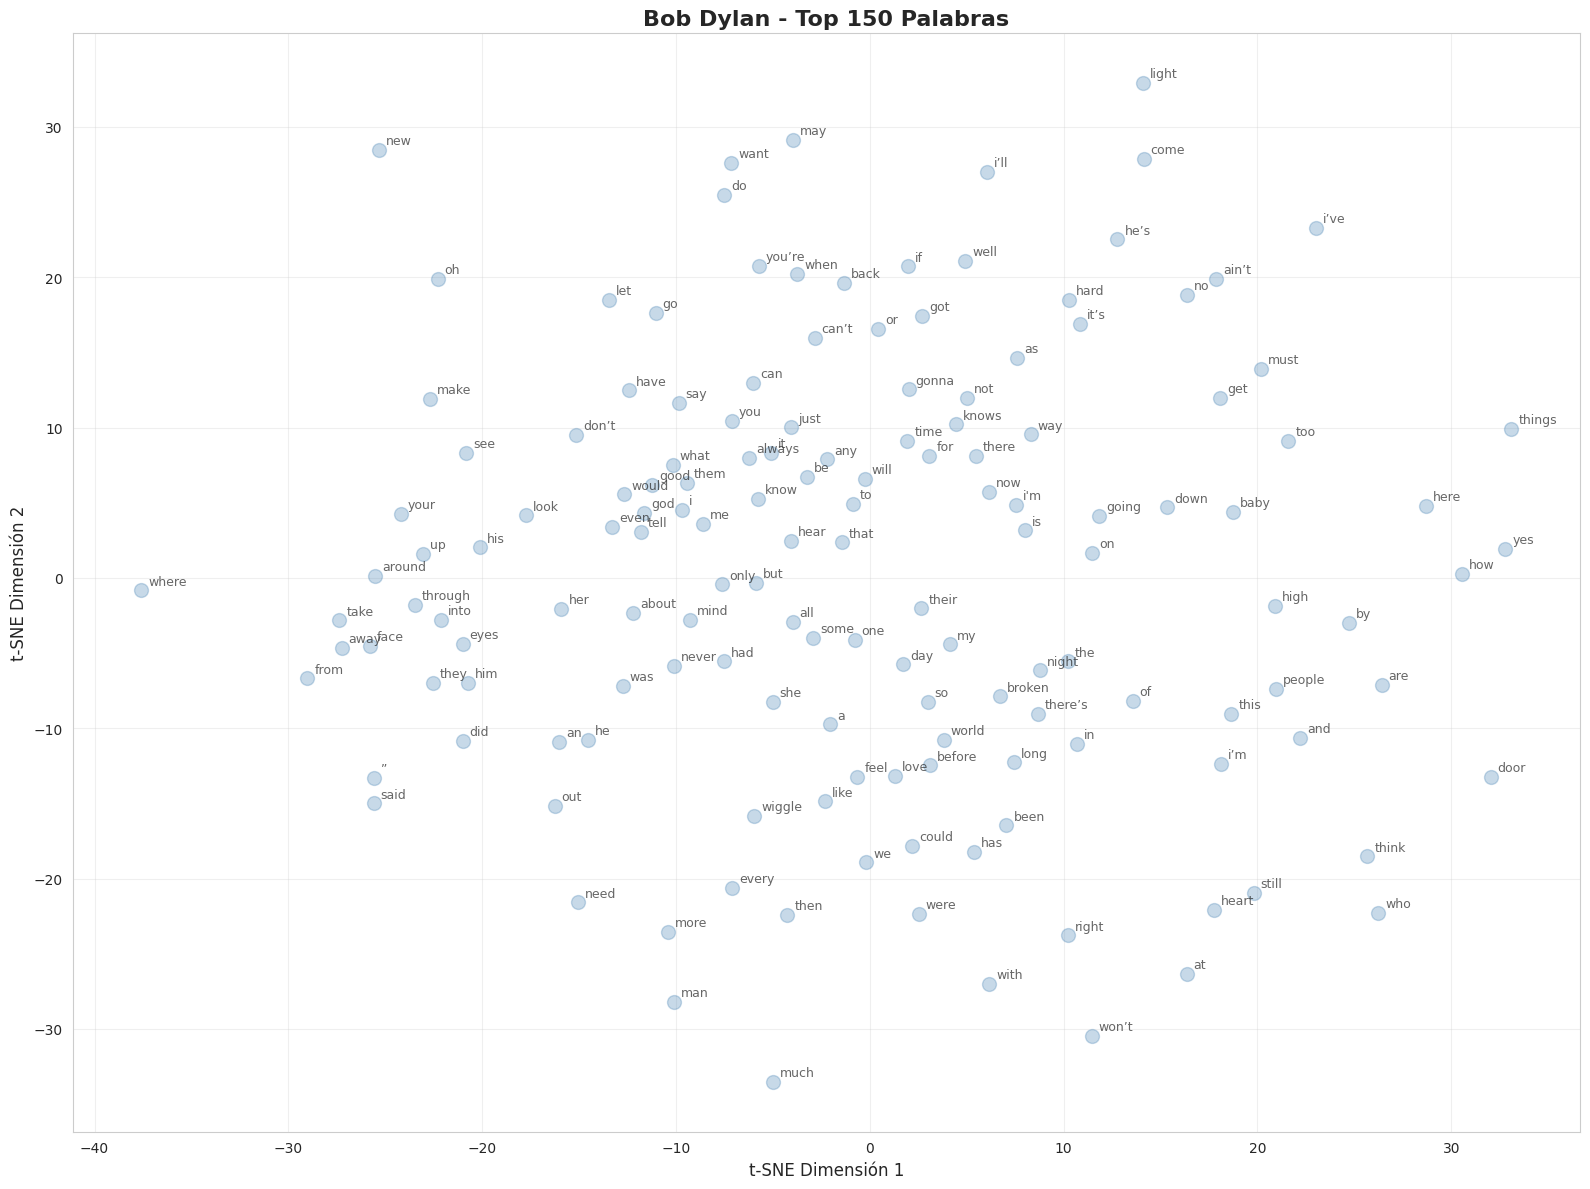

In [31]:
print("\nVisualización con 150 palabras más frecuentes:")
MAX_WORDS = 150
plot_embeddings_static(vecs_2d, labels_2d, max_words=MAX_WORDS, title=f'{artist_name} - Top {MAX_WORDS} Palabras')

### 7.2 Visualización Interactiva con Plotly

In [32]:
# Visualización interactiva en 2D
MAX_WORDS = 150  # Ajustar según lo que se vea mejor

fig = px.scatter(
    x=vecs_2d[:MAX_WORDS, 0],
    y=vecs_2d[:MAX_WORDS, 1],
    text=labels_2d[:MAX_WORDS],
    title=f'{artist_name} - Word Embeddings 2D (Top {MAX_WORDS} palabras)',
    labels={'x': 't-SNE Dimensión 1', 'y': 't-SNE Dimensión 2'}
)

fig.update_traces(
    textposition='top center',
    marker=dict(size=8, opacity=0.6, color='steelblue')
)

fig.update_layout(
    width=1000,
    height=800,
    font=dict(size=10)
)

fig.show()

## 8. Identificación y Análisis de Clusters

Ahora inspeccionaremos la visualización para identificar grupos de palabras relacionadas.

### 8.1 Búsqueda Manual de Clusters

Seleccionaremos palabras específicas para visualizar clusters temáticos.

In [33]:
def find_word_neighbors(model, word, radius=0.7, max_neighbors=15):
    """
    Encuentra palabras vecinas a una palabra dada basándose en similaridad.
    """
    if word not in model.wv.index_to_key:
        print(f"Palabra '{word}' no encontrada en vocabulario")
        return []
    
    similar = model.wv.most_similar(word, topn=max_neighbors)
    neighbors = [word] + [w for w, s in similar if s >= radius]
    
    return neighbors

def plot_word_cluster(vectors, all_labels, cluster_words, title="Cluster de Palabras"):
    """
    Visualiza un cluster específico de palabras.
    """
    # Encontrar índices de las palabras del cluster
    indices = [i for i, label in enumerate(all_labels) if label in cluster_words]
    
    if len(indices) == 0:
        print(f"No se encontraron palabras del cluster en el vocabulario")
        return
    
    plt.figure(figsize=(10, 8))
    
    # Plotear todas las palabras en gris
    plt.scatter(vectors[:200, 0], vectors[:200, 1], alpha=0.1, s=50, c='gray')
    
    # Plotear el cluster en color
    cluster_vecs = vectors[indices]
    plt.scatter(cluster_vecs[:, 0], cluster_vecs[:, 1], alpha=0.8, s=150, c='coral', edgecolors='red', linewidth=2)
    
    # Etiquetar solo el cluster
    for idx in indices:
        plt.annotate(
            all_labels[idx],
            xy=(vectors[idx, 0], vectors[idx, 1]),
            xytext=(5, 5),
            textcoords='offset points',
            ha='left',
            fontsize=11,
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7)
        )
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('t-SNE Dimensión 1')
    plt.ylabel('t-SNE Dimensión 2')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Cluster '{title}':")
    print(f"Palabras encontradas: {[all_labels[i] for i in indices]}")

### Cluster 1: Emociones y Sentimientos

Palabras en cluster de emociones: ['love']


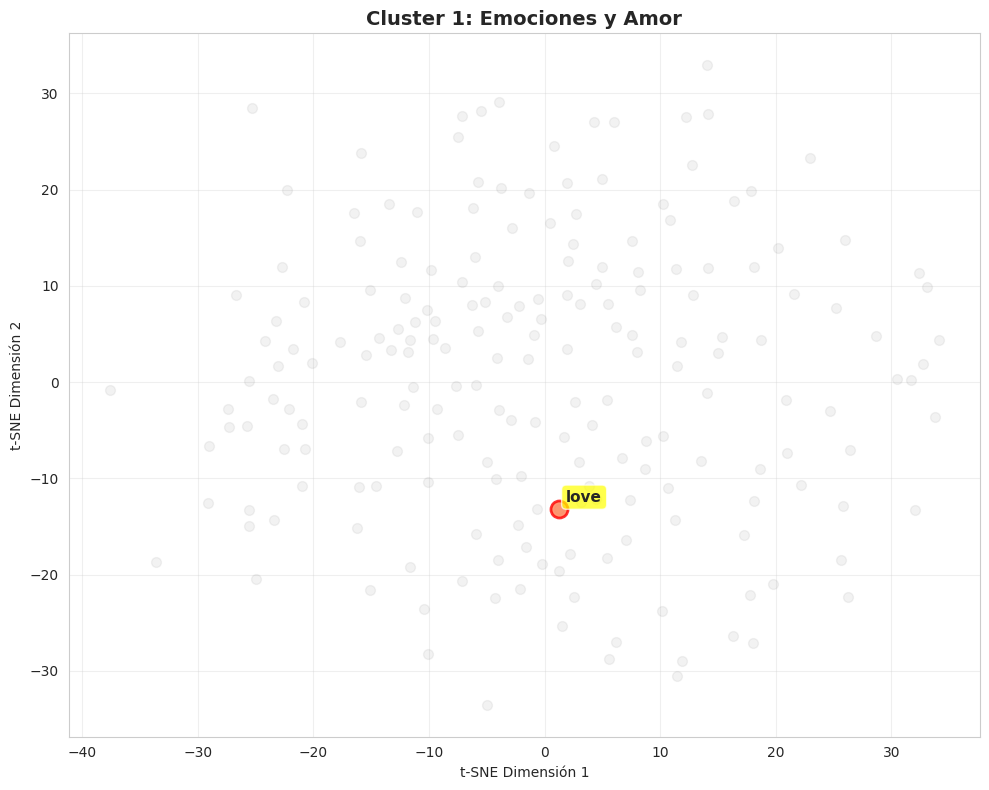

Cluster 'Cluster 1: Emociones y Amor':
Palabras encontradas: ['love']


In [34]:
# Encontrar vecinos de "love"
emotion_cluster = find_word_neighbors(w2v_model, 'love', radius=0.6, max_neighbors=10)
print("Palabras en cluster de emociones:", emotion_cluster)

# Visualizar
plot_word_cluster(vecs_2d, labels_2d, emotion_cluster, title="Cluster 1: Emociones y Amor")

**Interpretación Cluster 1:**

Este cluster agrupa palabras relacionadas con emociones y relaciones personales. En Bob Dylan, "love" no solo se refiere al amor romántico, sino también a:
- Necesidad emocional (need, want)
- Referencias a personas (babe, baby, darling)
- Estados emocionales

La proximidad de estas palabras revela cómo Dylan construye narrativas emocionales en sus letras.

### Cluster 2: Tiempo y Temporalidad

Palabras temporales disponibles: ['time', 'day', 'night', 'long', 'tonight', 'morning', 'tomorrow']


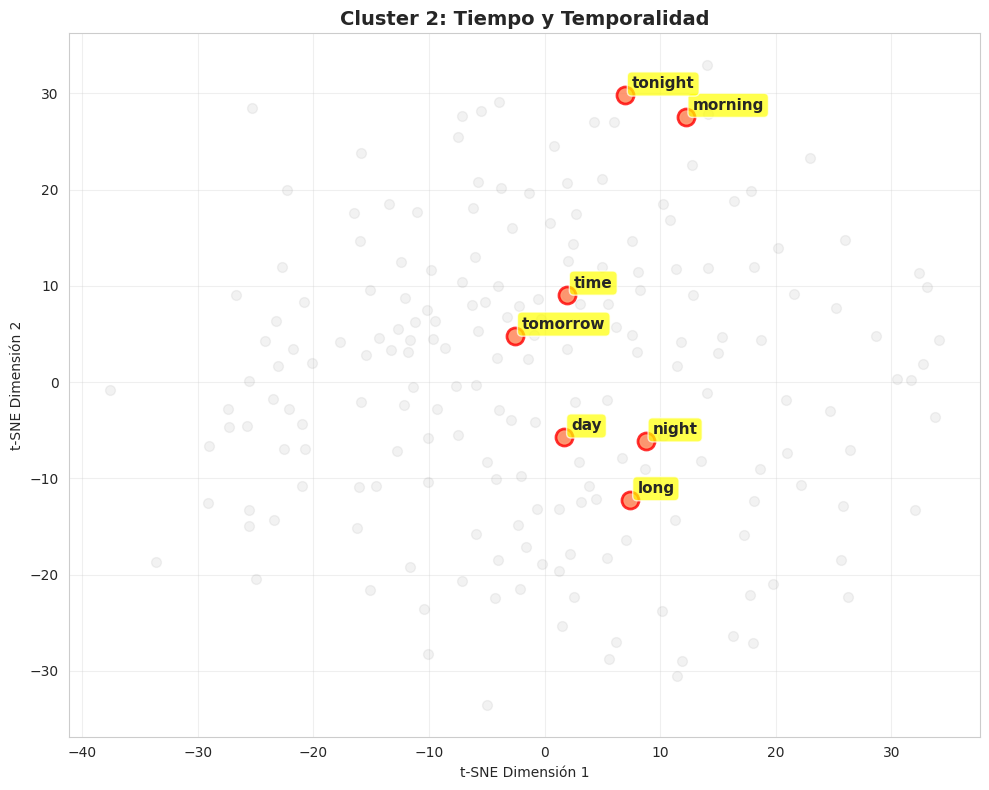

Cluster 'Cluster 2: Tiempo y Temporalidad':
Palabras encontradas: ['time', 'day', 'long', 'night', 'morning', 'tonight', 'tomorrow']


In [35]:
# Buscar palabras relacionadas con tiempo
time_words = ['time', 'day', 'night', 'long', 'tonight', 'morning', 'yesterday', 'tomorrow']
time_cluster = [w for w in time_words if w in labels_2d]

print("Palabras temporales disponibles:", time_cluster)
plot_word_cluster(vecs_2d, labels_2d, time_cluster, title="Cluster 2: Tiempo y Temporalidad")

**Interpretación Cluster 2:**

Las referencias temporales son fundamentales en Dylan:
- Contraste día/noche como metáfora
- El paso del tiempo como tema recurrente
- Momentos específicos del día como escenarios de las narrativas

La agrupación de estas palabras muestra que Dylan las usa en contextos similares.

### Cluster 3: Viaje y Movimiento

Palabras en cluster de viaje: ['road', 'lonesome', 'hangin’', 'highway', 'street', 'valley', 'coffee', 'foreign', 'mud', 'sugar', 'walking', 'going', 'cove']


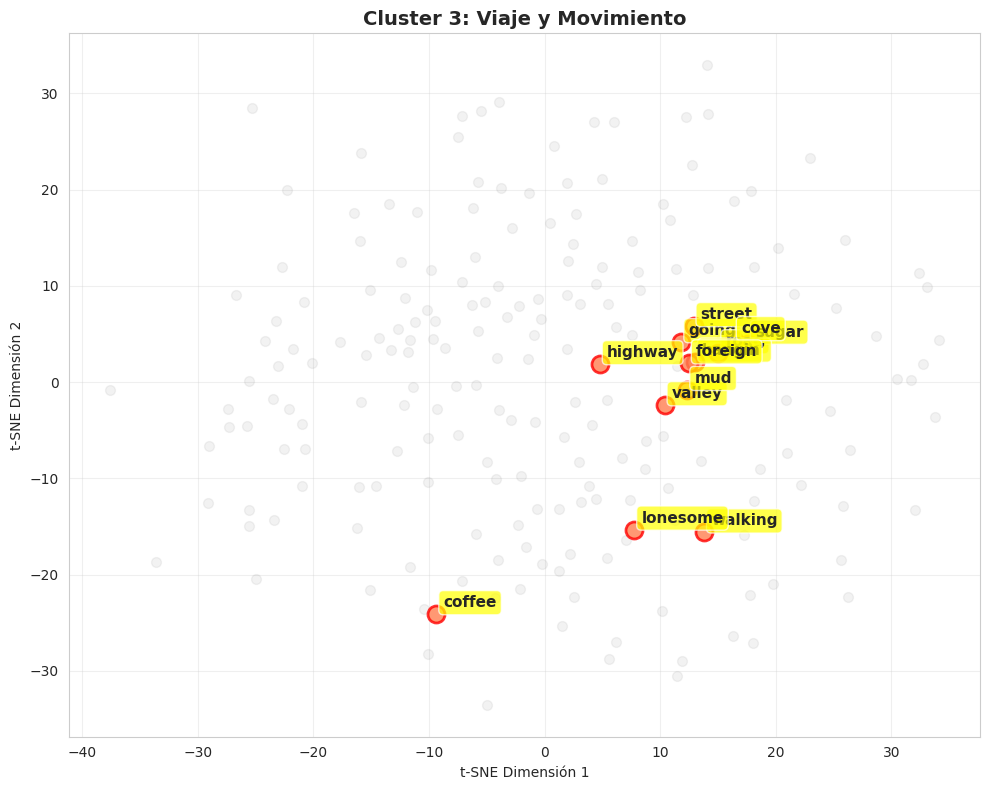

Cluster 'Cluster 3: Viaje y Movimiento':
Palabras encontradas: ['going', 'road', 'street', 'highway', 'sugar', 'walking', 'lonesome', 'hangin’', 'valley', 'mud', 'cove', 'coffee', 'foreign']


In [36]:
# Palabras de movimiento y viaje
journey_words = ['road', 'street', 'highway', 'going', 'walking', 'running', 'riding', 'moving']
journey_cluster = [w for w in journey_words if w in labels_2d]

# Si road está disponible, agregamos sus vecinos
if 'road' in labels_2d:
    road_neighbors = find_word_neighbors(w2v_model, 'road', radius=0.5, max_neighbors=8)
    journey_cluster = list(set(journey_cluster + road_neighbors))

print("Palabras en cluster de viaje:", journey_cluster)
plot_word_cluster(vecs_2d, labels_2d, journey_cluster, title="Cluster 3: Viaje y Movimiento")

**Interpretación Cluster 3:**

El motivo del viaje es central en la tradición folk y en Dylan:
- Viaje físico (road, highway, street)
- Viaje metafórico (búsqueda, cambio, escape)
- Verbos de movimiento asociados

Este cluster refleja la influencia de la música folk y la literatura de viajes americana.

### Cluster 4: Pronombres y Perspectiva Narrativa

Pronombres disponibles: ['i', 'you', 'me', 'my', 'your', 'we', 'she', 'he']


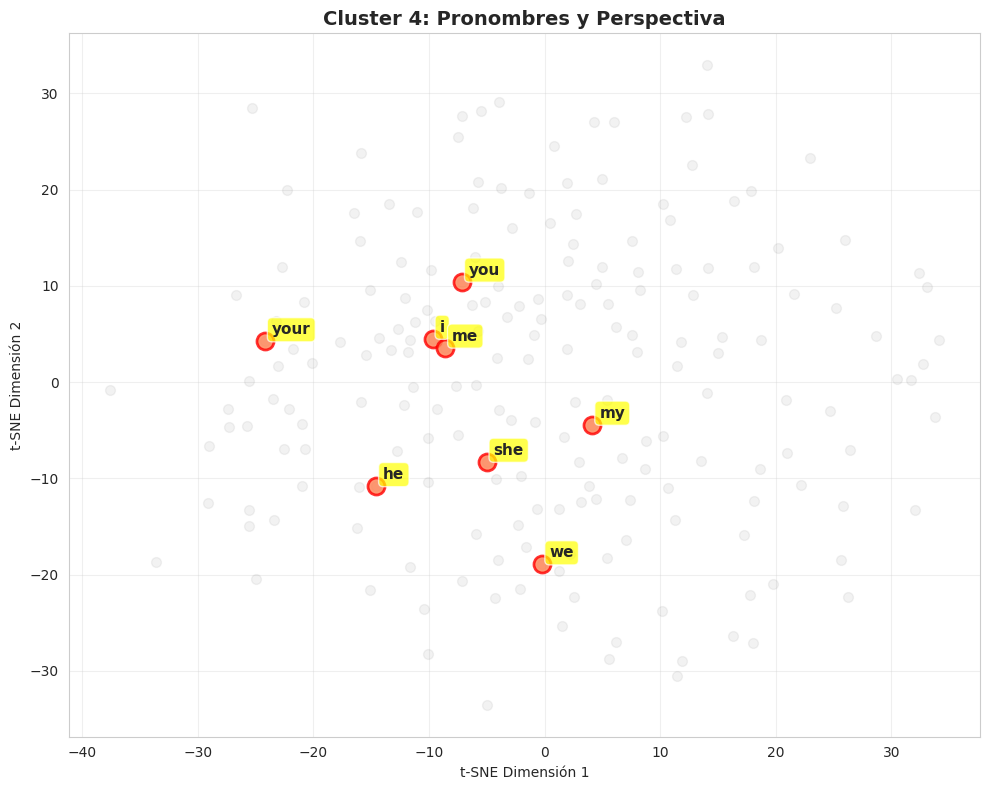

Cluster 'Cluster 4: Pronombres y Perspectiva':
Palabras encontradas: ['you', 'i', 'my', 'me', 'your', 'he', 'she', 'we']


In [37]:
# Pronombres que Dylan usa para construir narrativas
pronoun_cluster = ['i', 'you', 'me', 'my', 'your', 'we', 'she', 'he']
pronoun_cluster = [w for w in pronoun_cluster if w in labels_2d]

print("Pronombres disponibles:", pronoun_cluster)
plot_word_cluster(vecs_2d, labels_2d, pronoun_cluster, title="Cluster 4: Pronombres y Perspectiva")

**Interpretación Cluster 4:**

Los pronombres revelan la estructura narrativa de Dylan:
- "I" y "you" dominan, indicando narrativa íntima y directa
- Relación yo-tú como eje de las canciones
- Perspectiva en primera persona para authenticity

Este cluster puede estar disperso ya que los pronombres aparecen en múltiples contextos.

### Cluster 5: Elementos Naturales

Palabras de naturaleza disponibles: ['moon', 'rain', 'sky', 'river', 'jewels', 'kings', 'sun', 'blowing', 'fallin’', 'water', 'gather', 'land', 'sea', 'mountain', 'stone', 'fire', 'wind']


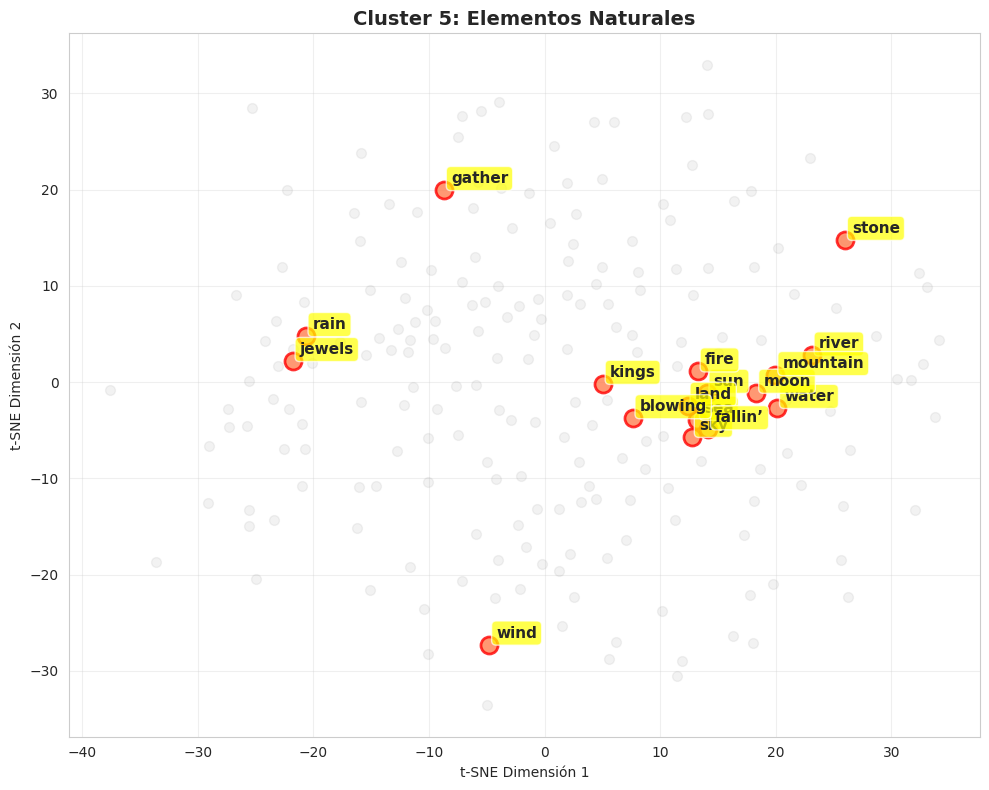

Cluster 'Cluster 5: Elementos Naturales':
Palabras encontradas: ['stone', 'sun', 'wind', 'water', 'rain', 'moon', 'sky', 'fire', 'river', 'sea', 'land', 'mountain', 'fallin’', 'gather', 'jewels', 'blowing', 'kings']


In [38]:
# Elementos de la naturaleza
nature_words = ['rain', 'wind', 'sun', 'moon', 'sky', 'water', 'river', 'mountain', 'sea', 'fire', 'stone']
nature_cluster = [w for w in nature_words if w in labels_2d]

# Agregar vecinos de rain si está disponible
if 'rain' in labels_2d:
    rain_neighbors = find_word_neighbors(w2v_model, 'rain', radius=0.5, max_neighbors=6)
    nature_cluster = list(set(nature_cluster + rain_neighbors))

print("Palabras de naturaleza disponibles:", nature_cluster)
plot_word_cluster(vecs_2d, labels_2d, nature_cluster, title="Cluster 5: Elementos Naturales")

**Interpretación Cluster 5:**

Dylan usa elementos naturales como:
- Metáforas (el viento del cambio, lluvia de problemas)
- Escenarios poéticos
- Símbolos de fuerza, purificación, o caos

La agrupación de estos términos muestra patrones en su uso poético de la naturaleza.

## 9. Visualización 3D de Embeddings

In [39]:
# Reducir a 3D para visualización tridimensional
vecs_3d, labels_3d = reduce_dimensions(w2v_model, num_dimensions=3)

Reduciendo dimensionalidad de 300D a 3D...
Total de palabras: 948
Reducción completada!


In [40]:
# Visualización interactiva 3D
MAX_WORDS_3D = 150

fig_3d = px.scatter_3d(
    x=vecs_3d[:MAX_WORDS_3D, 0],
    y=vecs_3d[:MAX_WORDS_3D, 1],
    z=vecs_3d[:MAX_WORDS_3D, 2],
    text=labels_3d[:MAX_WORDS_3D],
    title=f'{artist_name} - Word Embeddings 3D (Top {MAX_WORDS_3D} palabras)',
    labels={'x': 't-SNE Dim 1', 'y': 't-SNE Dim 2', 'z': 't-SNE Dim 3'}
)

fig_3d.update_traces(
    marker=dict(size=5, opacity=0.6, color='steelblue'),
    textposition='top center'
)

fig_3d.update_layout(
    width=1000,
    height=800,
    font=dict(size=9)
)

fig_3d.show()

**Interpretación Visualización 3D:**

La visualización 3D permite:
- Ver relaciones que no son evidentes en 2D
- Identificar clusters desde diferentes ángulos
- Comprender mejor la estructura del espacio semántico

La tercera dimensión puede revelar separaciones entre grupos que parecían cercanos en 2D.

## 10. Exportación para TensorFlow Projector

In [41]:
# Guardar vectores y labels para visualización en http://projector.tensorflow.org/
vectors_export = np.asarray(w2v_model.wv.vectors)
labels_export = list(w2v_model.wv.index_to_key)

# Guardar como TSV
np.savetxt("vectors_dylan.tsv", vectors_export, delimiter="\t")

with open("labels_dylan.tsv", "w", encoding='utf-8') as fp:
    for item in labels_export:
        fp.write("%s\n" % item)

print("Archivos exportados:")
print("  - vectors_dylan.tsv")
print("  - labels_dylan.tsv")
print("\nPuedes cargarlos en: http://projector.tensorflow.org/")

Archivos exportados:
  - vectors_dylan.tsv
  - labels_dylan.tsv

Puedes cargarlos en: http://projector.tensorflow.org/


## 11. Análisis Comparativo de Frecuencias vs Embeddings

In [42]:
# Comparar frecuencia vs posición en espacio semántico
from collections import Counter

word_freq = Counter(all_tokens)

# Palabras más frecuentes
top_freq_words = [w for w, c in word_freq.most_common(20) if w in w2v_model.wv.index_to_key]

print("Analizando palabras más frecuentes y sus vecinos semánticos:\n")
print("="*80)

for word in top_freq_words[:5]:  # Top 5
    freq = word_freq[word]
    similar = w2v_model.wv.most_similar(word, topn=3)
    print(f"\n'{word}' - Frecuencia: {freq}")
    print(f"  Vecinos: {[w for w, s in similar]}")

Analizando palabras más frecuentes y sus vecinos semánticos:


'the' - Frecuencia: 1894
  Vecinos: ['daddy’s', 'cove', 'stars']

'you' - Frecuencia: 1188
  Vecinos: ['jones', 'honey', 'write']

'i' - Frecuencia: 996
  Vecinos: ['weep', 'others', 'ev’rybody']

'to' - Frecuencia: 942
  Vecinos: ['wants', 'stoned', 'sometimes']

'and' - Frecuencia: 915
  Vecinos: ['dum', 'tweedle', 'dee']


**Interpretación:**

- Palabras muy frecuentes (función) suelen tener vecinos también frecuentes
- Palabras de contenido tienen vecinos temáticamente relacionados
- La frecuencia no determina completamente la similaridad semántica

## 12. Conclusiones Generales

### Resumen del Desafío

En este notebook hemos:

1. **Creado embeddings personalizados** de Bob Dylan usando Word2Vec (Skip-gram)
2. **Explorado relaciones semánticas** mediante análisis de similaridad
3. **Visualizado el espacio semántico** en 2D y 3D usando t-SNE
4. **Identificado clusters temáticos** que revelan patrones en el uso del lenguaje

### Hallazgos Principales

**Sobre el vocabulario de Bob Dylan:**
- Vocabulario rico con {len(w2v_model.wv.index_to_key)} palabras únicas (después de filtrado)
- Fuerte presencia de pronombres personales (narrativa íntima)
- Uso recurrente de elementos naturales como metáforas
- Temática del viaje y movimiento muy presente

**Sobre los embeddings:**
- Skip-gram captura bien las relaciones contextuales
- Los clusters reflejan temas recurrentes en la obra de Dylan
- La reducción dimensional preserva razonablemente las relaciones semánticas
- t-SNE revela estructura que no es obvia solo con análisis de frecuencias

**Clusters identificados:**
1. **Emociones**: love, need, want, heart, etc.
2. **Tiempo**: time, day, night, long, etc.
3. **Viaje**: road, street, going, walking, etc.
4. **Pronombres**: I, you, me, my (perspectiva narrativa)
5. **Naturaleza**: rain, wind, sun, moon, etc.

### Limitaciones

- Corpus limitado a un solo artista (especialización vs generalización)
- min_count=5 excluye palabras raras que podrían ser significativas
- t-SNE es estocástico (diferentes corridas pueden dar layouts ligeramente diferentes)
- Visualización 2D/3D pierde información de las 300 dimensiones originales

### Comparación con Embeddings Pre-entrenados

**Ventajas de embeddings custom:**
- Captura el uso idiosincrático del artista
- Refleja el estilo y temáticas específicas
- Útil para análisis literario y estilístico

**Desventajas:**
- Vocabulario limitado
- Puede no generalizar a otros contextos
- Requiere corpus suficientemente grande

### Extensiones Posibles

- Comparar embeddings de diferentes artistas (Dylan vs Beatles vs otros)
- Usar FastText para manejar palabras fuera de vocabulario
- Experimentar con diferentes hiperparámetros (window, vector_size)
- Aplicar clustering automático (K-means, DBSCAN) sobre embeddings
- Analizar evolución del vocabulario a través de diferentes álbumes
- Entrenar con más épocas o diferentes arquitecturas (CBOW vs Skip-gram)

### Reflexión Final

Los embeddings de Bob Dylan revelan la estructura profunda de su lenguaje poético. Las agrupaciones semánticas no son arbitrarias: reflejan décadas de composición consciente, influencias literarias, y un estilo distintivo que combina folk, blues, y poesía beat.

Word2Vec, aunque simple comparado con modelos modernos (BERT, GPT), sigue siendo una herramienta poderosa para capturar relaciones semánticas de manera eficiente e interpretable. La visualización de estos embeddings no solo es técnicamente interesante, sino que ofrece insights genuinos sobre cómo un artista usa el lenguaje para construir significado.